In [3]:
import tensorflow as tf
import numpy as np
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import sys
import datetime
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd


In [2]:
%load_ext tensorboard


In [7]:
# load cifar10 dataset
(trainX, trainy), (testX, testy)  = datasets.cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


50,000 examples in the training dataset and 10,000 in the test dataset and that images are square with 32×32 pixels and color, with three channels.

In [4]:
# unique lables
np.unique(testy) 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

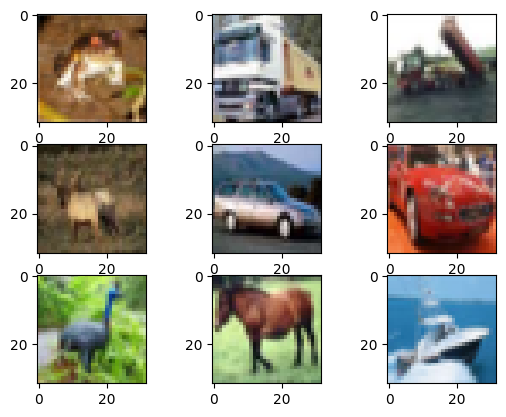

In [12]:
# plot first few images
def plot():
    for i in range(9):
        # define subplot
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(trainX[i])
        # show the figure
    plt.show()

plot()

Class Distribution

In [8]:

distribution = pd.DataFrame(trainy).value_counts()
for category, size in zip(distribution.index, distribution.values):
    print(f"{category} {size} images")

(0,) 5000 images
(1,) 5000 images
(2,) 5000 images
(3,) 5000 images
(4,) 5000 images
(5,) 5000 images
(6,) 5000 images
(7,) 5000 images
(8,) 5000 images
(9,) 5000 images


<Axes: title={'center': 'Distribution of classes'}, xlabel='0'>

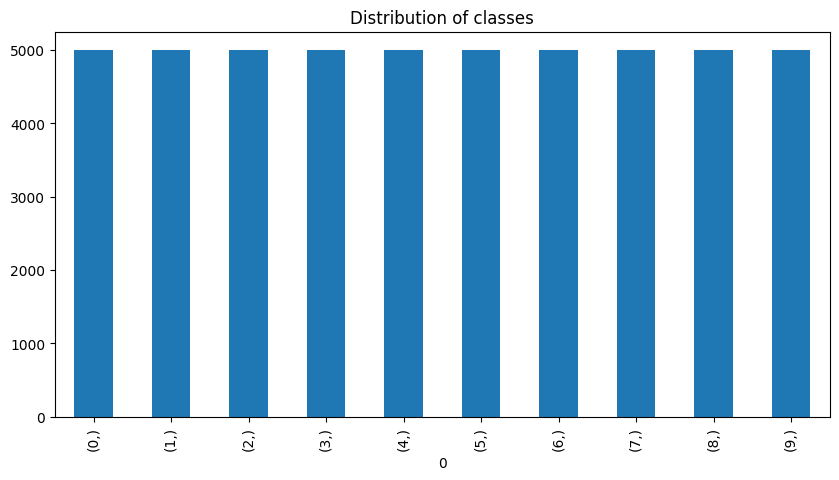

In [9]:
# Plot Distribution

plt.figure(figsize=(10, 5))
pd.DataFrame(trainy).value_counts().plot(kind='bar',
                                          title='Distribution of classes'
                                         )

This shows it is a balanced dataset

The images looks very small compared to modern photographs; it can be challenging to see what exactly is represented in some of the images given the extremely low resolution.

This low resolution could likely be the cause of the limited performance if so.

Since there 10 classes in the dataset and that classes are represented as unique integers.We will use one-hot encoding transforming the integer into a 10 element binary vector with a 1 for the index of the class value.

In [10]:
def load_dataset():
    # load cifar10 dataset
    (trainX, trainy), (testX, testy)  = datasets.cifar10.load_data()
    # summarize loaded dataset
    print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
    print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
     # one hot encode target values
    trainY = to_categorical(trainy)
    testY = to_categorical(testy)
    return trainX, trainY, testX, testY

Normalise the pixel values, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value. Here we make sure that different features are in the same scale and it also stabilises the gradient descent steps.

In [20]:

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

We can now investigate a baseline model for the CIFAR-10 dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.”

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

In [33]:
def define_model():
    # example of a 3-block vgg style architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(r"./logs/" + filename + '_plot.png')
    plt.close()

In [6]:
def train_steps():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=48, validation_split=0.20, verbose=1)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [35]:
# entry point, run the test harness
train_steps()

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


Epoch 1/100
834/834 [==============================] - 33s 39ms/step - loss: 1.7599 - accuracy: 0.3618 - val_loss: 1.4944 - val_accuracy: 0.4595
Epoch 2/100
834/834 [==============================] - 33s 40ms/step - loss: 1.3855 - accuracy: 0.5017 - val_loss: 1.3088 - val_accuracy: 0.5214
Epoch 3/100
834/834 [==============================] - 34s 41ms/step - loss: 1.2130 - accuracy: 0.5676 - val_loss: 1.1282 - val_accuracy: 0.6039
Epoch 4/100
834/834 [==============================] - 34s 41ms/step - loss: 1.0736 - accuracy: 0.6215 - val_loss: 1.0446 - val_accuracy: 0.6364
Epoch 5/100
834/834 [==============================] - 34s 41ms/step - loss: 0.9614 - accuracy: 0.6640 - val_loss: 0.9817 - val_accuracy: 0.6557
Epoch 6/100
834/834 [==============================] - 34s 41ms/step - loss: 0.8692 - accuracy: 0.6974 - val_loss: 0.9242 - val_accuracy: 0.6772
Epoch 7/100
834/834 [==============================] - 34s 41ms/step - loss: 0.7905 - accuracy: 0.7253 - val_loss: 0.9175 - val_ac

Test Accuracy: 73.530 on 3 blocks of vgg architecture

In [36]:
model = define_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

A figure is created and saved to file showing the learning curves of the model during training on the train and test dataset, both with regards to the loss and accuracy.

In this case, we can see that the model rapidly overfits the test dataset. This is clear if we look at the plot of loss (top plot), we can see that the model’s performance on the training dataset (blue) continues to improve whereas the performance on the test dataset (orange) improves, then starts to get worse at around 15 epochs.

In [12]:
# Clear any logs from previous runs
%rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Improving the model performance with adding dropout, ReduceLROnPlateau, and weight decay (excluding for now) <br>

Dropout: Dropout is a simple technique that will randomly drop nodes out of the network <br>
Weight Decay: Weight regularization or weight decay involves updating the loss function to penalize the model in proportion to the size of the model weights. This has a regularizing effect, as larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general.<br>
Early stopping: Stop training when a monitored metric has stopped improving <br>
ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. <br>

In [22]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# plot diagnostic learning curves
def summarize_diagnostics(history, file):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(r"../logs/" + filename + file)
    plt.close()

In [47]:
def train_steps():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    #ensures that logs are created and stored.
    #remove any previous logs
    print(model.summary())
    %rm -rf ./logs/
    log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # We'll stop training if no improvement after some epochs
    earlystopper = EarlyStopping(monitor='val_accuracy', patience=8, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8, 
                                   verbose=1, mode='max', min_lr=0.00001)
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=48, validation_split=0.20, callbacks=[earlystopper, reduce_lr, tensorboard_callback], verbose=1)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history, '3blocks_vgg_ver2.png')

    return model

In [48]:
model = train_steps()

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [13]:
%tensorboard --logdir=../logs/fit/20230916-143017 --port=8008
plt.show()

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

Test Accuracy: 80.700

Hyper parameter tuning

In [14]:
from keras_tuner import HyperModel
from tensorflow import keras

In [15]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=32,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            Conv2D(
                filters=64,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[64, 128],
                    default=64,
                ),
                activation='relu',
                kernel_size=3,
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )

        model.add(
            Conv2D(
                filters=128,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[128, 256],
                    default=128,
                ),
                activation='relu',
                kernel_size=3,
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )

        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation='relu'
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(32,32,3), num_classes=10)

In [16]:
from keras_tuner.tuners import Hyperband

SEED = 1
HYPERBAND_MAX_EPOCHS = 40
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2


tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='../logs/hyperband',
    project_name='cifar10'
)

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [13]:
N_EPOCH_SEARCH = 40 #to speed up the hyperparameter tuning
# load dataset
trainX, trainY, testX, testY = load_dataset()
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
earlystopper = EarlyStopping(monitor='val_accuracy', patience=8, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8, 
                                   verbose=1, mode='max', min_lr=0.00001)
tuner.search(trainX, trainY, epochs=N_EPOCH_SEARCH, callbacks=[earlystopper, reduce_lr], validation_split=0.1)

Trial 23 Complete [00h 30m 21s]
val_accuracy: 0.5857000052928925

Best val_accuracy So Far: 0.7170000076293945
Total elapsed time: 03h 00m 50s

Search: Running Trial #24

Value             |Best Value So Far |Hyperparameter
0                 |0                 |dropout_1
128               |128               |num_filters
0.25              |0                 |dropout_2
320               |320               |units
0.45              |0.1               |dropout_3
0.00078801        |0.00041268        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 402/1407 [=======>......................] - ETA: 40s - loss: 1.9061 - accuracy: 0.2952

1407/1407 [==============================] - 63s 44ms/step - loss: 1.5568 - accuracy: 0.4288 - val_loss: 1.1619 - val_accuracy: 0.5860 - lr: 7.8801e-04
Epoch 2/2
1407/1407 [==============================] - 1040s 739ms/step - loss: 1.0916 - accuracy: 0.6126 - val_loss: 0.8888 - val_accuracy: 0.6870 - lr: 7.8801e-04
Epoch 1/2
1407/1407 [==============================] - 1031s 733ms/step - loss: 1.5627 - accuracy: 0.4292 - val_loss: 1.1160 - val_accuracy: 0.6088 - lr: 7.8801e-04
Epoch 2/2
1046/1407 [=====================>........] - ETA: 24s - loss: 1.1088 - accuracy: 0.6075

Reducing the number of hyper parameters to be tuned to reduce processing time

In [21]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same',
                input_shape=self.input_shape
            )
        )
        model.add(
            Conv2D(
                filters=32,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same',
                kernel_size=3
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            Conv2D(
                filters=64,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(
            Conv2D(
                filters=64,
                activation='relu',
                kernel_size=3,
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.02,
                max_value=0.5,
                default=0.2,
                step=0.05,
            ))
        )

        model.add(
            Conv2D(
                filters=128,
                kernel_size=3,
                activation='relu',
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(
            Conv2D(
                filters=128,
                activation='relu',
                kernel_size=3,
                kernel_initializer='he_uniform', 
                padding='same'
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )

        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation='relu'
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.02,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(32,32,3), num_classes=10)

In [22]:
from keras_tuner.tuners import Hyperband

SEED = 1
HYPERBAND_MAX_EPOCHS = 10
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2


tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='../logs/hyperband',
    project_name='cifar10'
)

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.02, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.02, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [24]:

N_EPOCH_SEARCH = 10 #reduced to 10 to speed up the hyperparameter tuning
# load dataset
trainX, trainY, testX, testY = load_dataset()
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
earlystopper = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                                   verbose=1, mode='max', min_lr=0.00001)
tuner.search(trainX, trainY, epochs=N_EPOCH_SEARCH, callbacks=[earlystopper, reduce_lr], validation_split=0.1)

Trial 27 Complete [00h 55m 46s]
val_accuracy: 0.5900000035762787

Best val_accuracy So Far: 0.799699991941452
Total elapsed time: 04h 03m 40s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
0.15              |0.15              |dropout_1
0.07              |0.02              |dropout_2
192               |160               |units
0.22              |0.42              |dropout_3
0.00019559        |0.00079743        |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10
  31/1407 [..............................] - ETA: 56s - loss: 2.5521 - accuracy: 0.1028

1407/1407 [==============================] - 61s 43ms/step - loss: 1.7285 - accuracy: 0.3659 - val_loss: 1.3334 - val_accuracy: 0.5168 - lr: 1.9559e-04
Epoch 2/10
1407/1407 [==============================] - 68s 48ms/step - loss: 1.2762 - accuracy: 0.5440 - val_loss: 1.0573 - val_accuracy: 0.6166 - lr: 1.9559e-04
Epoch 3/10
1407/1407 [==============================] - 69s 49ms/step - loss: 1.0722 - accuracy: 0.6202 - val_loss: 0.9248 - val_accuracy: 0.6716 - lr: 1.9559e-04
Epoch 4/10
1407/1407 [==============================] - 71s 51ms/step - loss: 0.9387 - accuracy: 0.6721 - val_loss: 0.8775 - val_accuracy: 0.6950 - lr: 1.9559e-04
Epoch 5/10
1407/1407 [==============================] - 71s 50ms/step - loss: 0.8382 - accuracy: 0.7072 - val_loss: 0.7582 - val_accuracy: 0.7356 - lr: 1.9559e-04
Epoch 6/10
1407/1407 [==============================] - 71s 51ms/step - loss: 0.7516 - accuracy: 0.7358 - val_loss: 0.7200 - val_accuracy: 0.7474 - lr: 1.9559e-04
Epoch 7/10
1407/1407 [===========

In [ ]:
tuner.results_summary()

Results summary
Results in ../logs/hyperband/cifar10
Showing 10 best trials
Objective(name="val_accuracy", direction="max")


In [19]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print(best_hps.get_config()["values"])
# Build model
h_model = tuner.hypermodel.build(best_hps)

IndexError: list index out of range